In [1]:
from flash_ansr import ExpressionSpace, SkeletonPool, get_path

In [2]:
import numpy as np
import torch

In [3]:
pool = SkeletonPool.from_config(get_path('configs', 'v7.0', 'skeleton_pool_train.yaml'))
space = pool.expression_space

Compiling Skeletons: 100%|██████████| 4999/4999 [00:00<00:00, 31796.09it/s]


In [4]:
def modify_insert(expression: list[str], index: int, value: str) -> list[str]:
    expression.insert(index, value)
    return expression

def modify_remove(expression: list[str], index: int) -> list[str]:
    expression.pop(index)
    return expression

def modify_replace(expression: list[str], index: int, value: str) -> list[str]:
    expression[index] = value
    return expression

In [5]:
original = pool.sample_skeleton()[0]
original = [str(t) for t in original]
print(original)

['-', '/', 'abs', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '<num>']


In [6]:
def scramble(expression: list[str], steps: int | None = None) -> tuple[list[str], list[tuple[str, int, str | None]], list[tuple[str, int, str | None]]]:
    expression = expression.copy()
    steps = steps or len(expression)
    available_values = list(space.operator_arity.keys()) + list(space.variables)
    modifications = []
    reverse_modifications = []
    for _ in range(steps):
        operation = str(np.random.choice(['insert', 'remove', 'replace']))
        if operation == 'insert':
            index = np.random.randint(len(expression))
            value = str(np.random.choice(available_values))
            modifications.append((operation, index, value))
            reverse_modifications.append(('remove', index, None))
            expression = modify_insert(expression, index, value)
        elif operation == 'remove':
            index = np.random.randint(len(expression))
            modifications.append((operation, index, None))
            reverse_modifications.append(('insert', index, expression[index]))
            expression = modify_remove(expression, index)
        elif operation == 'replace':
            index = np.random.randint(len(expression))
            value = str(np.random.choice(available_values))
            modifications.append((operation, index, value))
            reverse_modifications.append(('replace', index, expression[index]))
            expression = modify_replace(expression, index, value)
    return expression, modifications, reverse_modifications[::-1]

In [7]:
def partial_transformations(source: list[str], modifications: list[tuple[str, int, str | None]]) -> list[list[str]]:
    targets = []
    target = source.copy()
    for operation, index, value in modifications:
        if operation == 'insert':
            target = modify_insert(target, index, value)
        elif operation == 'remove':
            target = modify_remove(target, index)
        elif operation == 'replace':
            target = modify_replace(target, index, value)
        targets.append(target.copy())
    return targets

In [8]:
available_values = list(space.operator_arity.keys()) + list(space.variables) + ['<num>'] + ['<pad>']
V = len(available_values)
action_space_size = 2 * V + 2

In [9]:
def action_to_logit(action: tuple[str, int, str | None]) -> int:
    if action[0] == 'remove':
        return 0
    elif action[0] == 'insert':
        return 1 + available_values.index(action[2])
    elif action[0] == 'replace':
        return 1 + V + available_values.index(action[2])
    elif action[0] == 'noop':
        return 1 + 2 * V

    raise ValueError(f'Invalid action: {action}')

def logit_to_action(logit: int) -> tuple[str, int, str | None]:
    if logit == 0:
        return 'remove', 0, None
    elif logit <= V:
        return 'insert', 0, available_values[logit - 1]
    elif logit <= 2 * V:
        return 'replace', 0, available_values[logit - 1 - V]
    else:
        return 'noop', 0, None

In [10]:
def create_tensors(source: list[str], modifications: list[tuple[str, int, str | None]], pad=True) -> list[list[str]]:
    targets = [source.copy()]
    target = source.copy()
    for operation, index, value in modifications[:-1]:
        if operation == 'insert':
            target = modify_insert(target, index, value)
        elif operation == 'remove':
            target = modify_remove(target, index)
        elif operation == 'replace':
            target = modify_replace(target, index, value)
        targets.append(target.copy())
        
    input_ids = [space.tokenizer.encode(t, return_tensors=False) for t in targets]
    logits = [action_to_logit(m) for m in modifications]

    if pad:
        max_length = max(len(t) for t in input_ids) + 1
        input_ids = [t + [0] * (max_length - len(t)) for t in input_ids]

    logits_tensor = torch.full((len(logits), max_length), action_to_logit(('noop', 0, None)), dtype=torch.long)
    for i in range(len(logits)):
        try:
            logits_tensor[i, modifications[i][1]] = logits[i]
        except IndexError:
            print(i, logits_tensor.shape, modifications[i], logits[i])
            raise

    return torch.tensor(input_ids), logits_tensor

In [11]:
scrambled, modifications, reverse_modifications = scramble(original)

In [12]:
print(scrambled)
print()

changed_expressions = partial_transformations(scrambled, reverse_modifications)
for expression in changed_expressions:
    print(expression)

print()
print(original)

['-', 'log', 'abs', 'pow3', 'pow5', '+', '<num>', 'atan', 'pow2', 'pow1_5', 'x2', 'pow1_5', '<num>', '<num>']

['-', 'log', 'abs', 'pow3', 'pow5', '+', '<num>', 'atan', 'pow2', 'pow1_5', 'x2', '<num>', '<num>']
['-', 'log', 'abs', 'pow5', '+', '<num>', 'atan', 'pow2', 'pow1_5', 'x2', '<num>', '<num>']
['-', 'log', 'abs', 'pow5', '+', '<num>', 'atan', 'pow2', 'x2', '<num>', '<num>']
['-', 'log', 'abs', '+', '<num>', 'atan', 'pow2', 'x2', '<num>', '<num>']
['-', '/', 'abs', '+', '<num>', 'atan', 'pow2', 'x2', '<num>', '<num>']
['-', '/', 'abs', '+', '<num>', 'atan', 'pow2', 'x2', 'log', '<num>', '<num>']
['-', '/', 'abs', '+', '<num>', 'pow2', 'x2', 'log', '<num>', '<num>']
['-', '/', 'abs', '+', '<num>', 'pow4', 'pow2', 'x2', 'log', '<num>', '<num>']
['-', '/', 'abs', '+', '<num>', 'pow2', 'x2', 'log', '<num>', '<num>']
['-', '/', 'abs', '+', '<num>', '+', 'x2', 'log', '<num>', '<num>']
['-', '/', 'abs', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '<num>']

['-', '/', 'abs', '+', '<n

In [13]:
input_ids, logits = create_tensors(scrambled, reverse_modifications)
print(input_ids)
print(logits)

tensor([[ 8, 29, 12, 15, 17,  7,  6, 27, 14, 21, 31, 21,  6,  6,  0],
        [ 8, 29, 12, 15, 17,  7,  6, 27, 14, 21, 31,  6,  6,  0,  0],
        [ 8, 29, 12, 17,  7,  6, 27, 14, 21, 31,  6,  6,  0,  0,  0],
        [ 8, 29, 12, 17,  7,  6, 27, 14, 31,  6,  6,  0,  0,  0,  0],
        [ 8, 29, 12,  7,  6, 27, 14, 31,  6,  6,  0,  0,  0,  0,  0],
        [ 8, 11, 12,  7,  6, 27, 14, 31,  6,  6,  0,  0,  0,  0,  0],
        [ 8, 11, 12,  7,  6, 27, 14, 31, 29,  6,  6,  0,  0,  0,  0],
        [ 8, 11, 12,  7,  6, 14, 31, 29,  6,  6,  0,  0,  0,  0,  0],
        [ 8, 11, 12,  7,  6, 16, 14, 31, 29,  6,  6,  0,  0,  0,  0],
        [ 8, 11, 12,  7,  6, 14, 31, 29,  6,  6,  0,  0,  0,  0,  0],
        [ 8, 11, 12,  7,  6,  7, 31, 29,  6,  6,  0,  0,  0,  0,  0]])
tensor([[57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,  0, 57, 57, 57],
        [57, 57, 57,  0, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57],
        [57, 57, 57, 57, 57, 57, 57, 57,  0, 57, 57, 57, 57, 57, 57],
        [57, 57, 57

In [72]:
def sample_instance(skeleton):
    scrambled, _, reverse_modifications = scramble(skeleton, 1)
    input_ids, logits = create_tensors(scrambled, reverse_modifications)
    return input_ids, logits

In [73]:
# %%timeit
# sample_instance(original)

In [74]:
available_values = list(space.operator_arity.keys()) + list(space.variables) + ['<num>']
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [75]:
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from flash_ansr.models.transformer_utils import PositionalEncoding

In [105]:
class ANSRDiffuser(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.positional_encoding = PositionalEncoding()
        self.embedding = nn.Embedding(len(space.tokenizer.vocab), size)
        self.transformer_decoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=size, dim_feedforward=size*4, nhead=8, batch_first=True),
            num_layers=5
        )
        self.head = nn.Linear(size, action_space_size)

    def forward(self, x):
        x = self.embedding(x)
        x * x + self.positional_encoding(x)
        x = self.transformer_decoder(x)
        return self.head(x)
    
    @property
    def n_params(self):
        return sum(p.numel() for p in self.parameters())

In [106]:
model = ANSRDiffuser(size=128).to(device)
print(f'Number of parameters: {model.n_params:,}')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
loss_fn = nn.CrossEntropyLoss(ignore_index=action_to_logit(('noop', 0, None)))

Number of parameters: 1,003,066


In [108]:
history = []

pbar = tqdm(range(100_000))

for i in pbar:
    input_ids, logits = sample_instance(original)
    input_ids, logits = input_ids.to(device), logits.to(device)

    optimizer.zero_grad()
    output = model(input_ids)

    output = output.view(-1, action_space_size)
    logits = logits.view(-1)
    
    loss = loss_fn(output, logits)
    loss.backward()
    optimizer.step()

    history.append(loss.item())

    pbar.set_postfix_str(f'Loss: {loss.item():.4f}')

  1%|          | 677/100000 [00:04<10:57, 151.00it/s, Loss: 0.0022]


KeyboardInterrupt: 

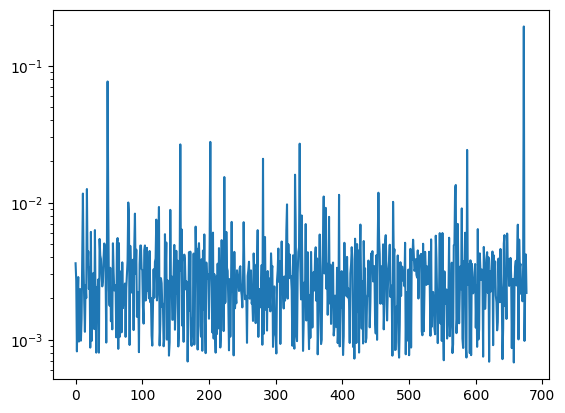

In [109]:
plt.plot(history)
plt.yscale('log')

In [110]:
def sample_action(model, input_ids):
    with torch.no_grad():
        output = model(input_ids.unsqueeze(0))
        # Sample an action from all logits at all positions
        action = torch.multinomial(output.view(-1).softmax(0), 1).item()
        position = action // action_space_size
        logit = action % action_space_size
        return position, logit_to_action(logit)

In [111]:
input_ids = space.tokenizer.encode(scrambled, return_tensors=True).to(device)
# model(input_ids.unsqueeze(0))
sample_action(model, input_ids)

(6, ('replace', 0, 'x2'))

In [112]:
input_ids.shape

torch.Size([11])

In [113]:
scrambled, _, reverse_modifications = scramble(original, 1)

In [143]:
reconstruction = scrambled.copy()

for _ in range(16):
    input_ids = space.tokenizer.encode(reconstruction, return_tensors=True).to(device)
    position, action = sample_action(model, input_ids)
    operation, _, value = action
    print(reconstruction)
    if operation == 'insert':
        reconstruction = modify_insert(reconstruction, position, value)
    elif operation == 'remove':
        reconstruction = modify_remove(reconstruction, position)
    elif operation == 'replace':
        reconstruction = modify_replace(reconstruction, position, value)
    if reconstruction == original:
        print('---')

print(original)

['-', '/', 'abs', 'neg', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '<num>']
['-', '/', 'abs', 'neg', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '<num>']
---
['-', '/', 'abs', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '<num>']
---
['-', '/', 'abs', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '<num>']
['-', '/', 'abs', '+', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '<num>']
---
['-', '/', 'abs', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '<num>']
---
['-', '/', 'abs', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '<num>']
---
['-', '/', 'abs', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '<num>']
['-', '/', 'abs', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '+', '<num>']
['-', 'abs', '+', '<num>', '+', 'x2', 'log', 'x1', '<num>', '+', '<num>']
['-', 'abs', '/', '<num>', '+', 'x2', 'log', 'x1', '<num>', '+', '<num>']
['-', 'abs', '/', '<num>', '+', 'x2', 'log', 'x1', '<num>', '+', '<num>']
['abs', '/', '<num>', '+', 'x2', 'log', 'x1', '<num>', '+', '<num>']

---

In [43]:
from Levenshtein import editops, apply_edit

In [61]:
scrambled, modifications, reverse_modifications = scramble(original)
best_reverse_modifications = editops(tuple(scrambled), tuple(original))
scrambled = [str(t) for t in scrambled]
print(original)
print(scrambled)
print()
print(modifications)
print()
print(reverse_modifications)
print()
print(best_reverse_modifications)

['/', '<num>', '*', 'x3', '+', 'x1', '+', 'x2', '/', 'x2', 'pow2', 'x2']
['/', '-', 'atan', '*', 'pow2', 'abs', '*', 'log', 'abs', '+', 'x2', 'pow1_2', 'cos', 'x2', 'pow2', 'exp']

[('remove', 4, None), ('replace', 3, 'log'), ('insert', 2, '*'), ('replace', 11, 'exp'), ('replace', 1, 'atan'), ('replace', 5, 'abs'), ('insert', 3, 'pow2'), ('insert', 4, 'log'), ('insert', 1, '-'), ('insert', 11, 'pow1_2'), ('replace', 5, 'abs'), ('replace', 12, 'cos')]

[('replace', 12, '/'), ('replace', 5, 'log'), ('remove', 11, None), ('remove', 1, None), ('remove', 4, None), ('remove', 3, None), ('replace', 5, 'x1'), ('replace', 1, '<num>'), ('replace', 11, 'x2'), ('remove', 2, None), ('replace', 3, 'x3'), ('insert', 4, '+')]

[('replace', 1, 1), ('delete', 2, 2), ('replace', 4, 3), ('replace', 5, 4), ('replace', 6, 5), ('delete', 7, 6), ('delete', 8, 6), ('replace', 11, 8), ('delete', 12, 9), ('replace', 15, 11)]


In [113]:
def create_partial_reconstructions(source: list[str], target: list[str], modifications: list[tuple[str, int, int]]) -> list[list[str]]:
    partial_reconstructions = []
    partial_reconstruction = source.copy()
    index_shift = np.zeros(len(target), dtype=int)
    for operation, index_source, index_target in modifications:
        print(operation, index_source, index_target)
        print(operation, index_source + np.cumsum(index_shift)[index_source], index_target)
        if operation == 'insert':
            partial_reconstruction.insert(index_source, target[index_target])
            index_shift[index_target] += 1
        elif operation == 'delete':
            partial_reconstruction.pop(index_source)
            index_shift[index_target] -= 1
        elif operation == 'replace':
            partial_reconstruction[index_source + np.cumsum(index_shift)[index_source]] = target[index_target]
        print(partial_reconstruction)
        partial_reconstructions.append(partial_reconstruction.copy())
    return partial_reconstructions

In [114]:
print(scrambled)
print()

for rec in create_partial_reconstructions(scrambled, original, best_reverse_modifications):
    print(rec)
    print()

print(original)

assert create_partial_reconstructions(scrambled, original, best_reverse_modifications)[-1] == original

['/', '-', 'atan', '*', 'pow2', 'abs', '*', 'log', 'abs', '+', 'x2', 'pow1_2', 'cos', 'x2', 'pow2', 'exp']

replace 1 1
replace 1 1
['/', '<num>', 'atan', '*', 'pow2', 'abs', '*', 'log', 'abs', '+', 'x2', 'pow1_2', 'cos', 'x2', 'pow2', 'exp']
delete 2 2
delete 2 2
['/', '<num>', '*', 'pow2', 'abs', '*', 'log', 'abs', '+', 'x2', 'pow1_2', 'cos', 'x2', 'pow2', 'exp']
replace 4 3
replace 3 3
['/', '<num>', '*', 'x3', 'abs', '*', 'log', 'abs', '+', 'x2', 'pow1_2', 'cos', 'x2', 'pow2', 'exp']
replace 5 4
replace 4 4
['/', '<num>', '*', 'x3', '+', '*', 'log', 'abs', '+', 'x2', 'pow1_2', 'cos', 'x2', 'pow2', 'exp']
replace 6 5
replace 5 5
['/', '<num>', '*', 'x3', '+', 'x1', 'log', 'abs', '+', 'x2', 'pow1_2', 'cos', 'x2', 'pow2', 'exp']
delete 7 6
delete 6 6
['/', '<num>', '*', 'x3', '+', 'x1', 'log', '+', 'x2', 'pow1_2', 'cos', 'x2', 'pow2', 'exp']
delete 8 6
delete 6 6
['/', '<num>', '*', 'x3', '+', 'x1', 'log', '+', 'pow1_2', 'cos', 'x2', 'pow2', 'exp']
replace 11 8
replace 8 8
['/', '<num

IndexError: index 12 is out of bounds for axis 0 with size 12

In [8]:
reconstructed = scrambled.copy()
for operation, index, value in reverse_modifications:
    if operation == 'insert':
        reconstructed = modify_insert(reconstructed, index, value)
    elif operation == 'remove':
        reconstructed = modify_remove(reconstructed, index)
    elif operation == 'replace':
        reconstructed = modify_replace(reconstructed, index, value)
reconstructed = [str(t) for t in reconstructed]
print()
print(reconstructed)
print()
assert original == reconstructed


['/', '<num>', '*', 'x3', '+', 'x1', '+', 'x2', '/', 'x2', 'pow2', 'x2']



In [9]:
input_ids = scrambled
action = reverse_modifications[0]
print(input_ids, action)

['+', '/', 'x2', '<num>', '*', '+', 'x1', 'asin', 'x2', '/', 'x3', '*', '+'] ('insert', 11, 'pow1_2')


In [10]:
def action_to_logit(action: tuple[str, int, str | None]) -> int:
    available_values = list(space.operator_arity.keys()) + list(space.variables)
    V = len(available_values)

    if action[0] == 'remove':
        return 0
    elif action[0] == 'insert':
        return 1 + available_values.index(action[2])
    elif action[0] == 'replace':
        return 1 + V + available_values.index(action[2])

    raise ValueError(f'Invalid action: {action}')

In [11]:
logit = action_to_logit(action)
print(logit)

12
